<a href="https://colab.research.google.com/github/fshnkarimi/Labeling/blob/Afshin/Time_Series_Labelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Reading Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
dfs = pd.read_excel("000001data.xlsx")

Implementing Labelling algorithm 

In [16]:
#labelling algorithm X is price and w is our threshould
def labeling(X,w):
    n = len(X)
    y = np.array([0 for i in range(n)])
    FP=X[0]
    xh = X[0]
    xl = X[0]
    HT = 0
    LT = 0
    cid = 0
    FP_N = 0
    for i in range(n):
        if(X[i] > FP + X[0]*w):
            xh,HT,FP_N,cid  = X[i],i,i,1
            break
        if(X[i] < FP - X[0]*w):
            xh,HT,FP_N,cid  = X[i],i,i,-1
            break
    for i in range(FP_N+1,n):
        if(cid > 0):
            if(X[i]>xh):
                xh,HT = X[i],i
            if(X[i] < xh - xh*w and LT<= HT ):
                for j in range(n):
                    if(j>LT and j<=HT):
                        y[j] = 1
                xl,LT,cid = X[i],i,-1
        if(cid < 0):
            if(X[i]<xl):
                xl,LT = X[i],i
            if(X[i] > xl + xl*w and HT<= LT ):
                for j in range(n):
                    if(j>HT and j<=LT):
                        y[j] = -1
                xh,HT,cid = X[i],i,1
    return y

labelling data

In [17]:
label=labeling(dfs["closingprice"],0.15)    

Creat windows with size 11 

In [18]:
closing_price= dfs['closingprice']

#windows size is 11
expand_data = np.array([closing_price[i:i+11] for i in range(len(closing_price) - 10) ])

normalize Data 
\begin{align*}
        f_{ij} & = \frac{x_{ij} - M^{\lambda}_{i}}{M^{\lambda}_{i}} ,x_{ij} \in X\\
        M^{\lambda}_{s}& = \frac{\sum_{i=s}^{s+ \lambda -1} x_i}{\lambda} , x_i \in x
    \end{align*}

In [19]:
#normalizatin
final_data_x = expand_data / np.mean(expand_data,axis = 1).reshape((len(expand_data) , 1))
final_data_x = final_data_x - np.ones((len(final_data_x) ,1))

In [20]:
#finalizing data
final_data_y = label[10:]
#split data to test and train
x_train = final_data_x[0:3011]
y_train = final_data_y[0:3011]
x_test= final_data_x[3011:]
y_test = final_data_y[3011:]

#(-1,1) --> (0,1)
y_train = (y_train + 1)//2
y_test = (y_test + 1)//2

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)



In [21]:
# Define a def for scores

from sklearn import metrics
import seaborn as sns

def scores(y_pred, label):
    results=[]
    results.append(metrics.accuracy_score(label, y_pred))
    results.append(metrics.precision_score(label, y_pred))
    results.append(metrics.recall_score(label, y_pred))
    results.append(metrics.f1_score(label, y_pred))
    print("Accuracy:{:.6f}".format(metrics.accuracy_score(label, y_pred)))
    print("Precision:{:.6f}".format(metrics.precision_score(label, y_pred)))
    print("Recall:{:.6f}".format(metrics.recall_score(label, y_pred)))
    print("F1 score:{:.6f}".format(metrics.f1_score(label, y_pred)))
    # Print Confusion Matrix
    confusion_matrix = pd.DataFrame(metrics.confusion_matrix(label, y_pred)) 
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues");
    return results

Training data with 2 layer LSTM with hidden size 50 

Epoch 1/20
48/48 - 2s - loss: 0.6598 - accuracy: 0.6088 - val_loss: 0.6304 - val_accuracy: 0.6699
Epoch 2/20
48/48 - 0s - loss: 0.5913 - accuracy: 0.6998 - val_loss: 0.7088 - val_accuracy: 0.5570
Epoch 3/20
48/48 - 0s - loss: 0.5977 - accuracy: 0.6838 - val_loss: 0.5989 - val_accuracy: 0.6816
Epoch 4/20
48/48 - 0s - loss: 0.5599 - accuracy: 0.7197 - val_loss: 0.6442 - val_accuracy: 0.6297
Epoch 5/20
48/48 - 0s - loss: 0.5475 - accuracy: 0.7253 - val_loss: 0.6625 - val_accuracy: 0.6185
Epoch 6/20
48/48 - 0s - loss: 0.5515 - accuracy: 0.7250 - val_loss: 0.6003 - val_accuracy: 0.6782
Epoch 7/20
48/48 - 0s - loss: 0.5381 - accuracy: 0.7320 - val_loss: 0.5987 - val_accuracy: 0.6743
Epoch 8/20
48/48 - 0s - loss: 0.5374 - accuracy: 0.7310 - val_loss: 0.5966 - val_accuracy: 0.6795
Epoch 9/20
48/48 - 1s - loss: 0.5344 - accuracy: 0.7370 - val_loss: 0.5896 - val_accuracy: 0.6837
Epoch 10/20
48/48 - 0s - loss: 0.5328 - accuracy: 0.7403 - val_loss: 0.5943 - val_accuracy: 0.6850
Epoch 11/20
48/48 -

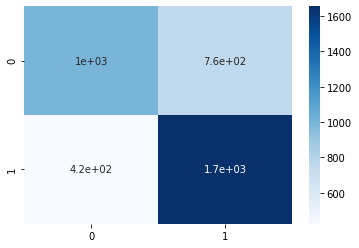

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50,return_sequences=True,input_shape=(11,1)))
  model.add(Dropout(0.1))
  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)
  
  # Predictions on test data
  preds = model.predict(x_test)
  preds = np.array([1 if y >= 0.5 else 0 for y in preds])
  lstm_results = scores(preds, y_test)

In [23]:
lstm_results

[0.6925684485006519, 0.6867219917012448, 0.796055796055796, 0.7373579861884607]

Training data with 2 layer GRU with hidden size 50 

Epoch 1/20
48/48 - 2s - loss: 0.6340 - accuracy: 0.6387 - val_loss: 0.6054 - val_accuracy: 0.6696
Epoch 2/20
48/48 - 0s - loss: 0.5625 - accuracy: 0.7184 - val_loss: 0.5981 - val_accuracy: 0.6806
Epoch 3/20
48/48 - 0s - loss: 0.5496 - accuracy: 0.7224 - val_loss: 0.5979 - val_accuracy: 0.6829
Epoch 4/20
48/48 - 0s - loss: 0.5390 - accuracy: 0.7343 - val_loss: 0.6022 - val_accuracy: 0.6686
Epoch 5/20
48/48 - 0s - loss: 0.5335 - accuracy: 0.7386 - val_loss: 0.5848 - val_accuracy: 0.6892
Epoch 6/20
48/48 - 0s - loss: 0.5235 - accuracy: 0.7340 - val_loss: 0.6334 - val_accuracy: 0.6801
Epoch 7/20
48/48 - 0s - loss: 0.5224 - accuracy: 0.7403 - val_loss: 0.5923 - val_accuracy: 0.6887
Epoch 8/20
48/48 - 0s - loss: 0.5208 - accuracy: 0.7390 - val_loss: 0.6211 - val_accuracy: 0.6754
Epoch 9/20
48/48 - 0s - loss: 0.5288 - accuracy: 0.7370 - val_loss: 0.6111 - val_accuracy: 0.6691
Epoch 10/20
48/48 - 0s - loss: 0.5112 - accuracy: 0.7489 - val_loss: 0.6135 - val_accuracy: 0.6621
Epoch 11/20
48/48 -

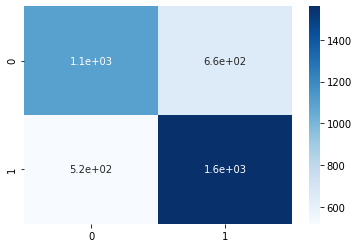

In [24]:
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50,return_sequences=True,input_shape=(11,1)))
  model.add(Dropout(0.1))
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)

  # Predictions on test data
  preds = model.predict(x_test)
  preds = np.array([1 if y >= 0.5 else 0 for y in preds])
  gru_results = scores(preds, y_test)

In [25]:
gru_results

[0.6933507170795307,
 0.7036535859269283,
 0.7503607503607503,
 0.7262569832402236]

Training data with XGBoost

[0]	validation_0-auc:0.731009
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.731291
[2]	validation_0-auc:0.731218
[3]	validation_0-auc:0.731854
[4]	validation_0-auc:0.732589
[5]	validation_0-auc:0.732487
[6]	validation_0-auc:0.740994
[7]	validation_0-auc:0.743101
[8]	validation_0-auc:0.743565
[9]	validation_0-auc:0.742532
[10]	validation_0-auc:0.742988
[11]	validation_0-auc:0.742518
[12]	validation_0-auc:0.743228
[13]	validation_0-auc:0.74337
[14]	validation_0-auc:0.743477
[15]	validation_0-auc:0.743484
[16]	validation_0-auc:0.743919
[17]	validation_0-auc:0.74442
[18]	validation_0-auc:0.744942
[19]	validation_0-auc:0.74594
[20]	validation_0-auc:0.745706
[21]	validation_0-auc:0.746255
[22]	validation_0-auc:0.746086
[23]	validation_0-auc:0.746581
[24]	validation_0-auc:0.746946
[25]	validation_0-auc:0.746795
[26]	validation_0-auc:0.747
[27]	validation_0-auc:0.747143
[28]	validation_0-auc:0.74756
[29]	validation_0-auc:0.747364
[30]	validation_0-auc:0

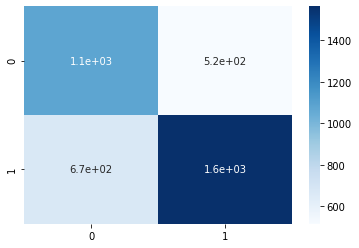

In [26]:
import xgboost as xgb
import numpy as np

X_train = x_train.reshape(x_train.shape[0],x_train.shape[1])
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1])

# XGBoost classifier with Early-stopping
clf = xgb.XGBClassifier(n_jobs=1)
clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="auc",
        eval_set=[(X_test, y_test)])

preds = clf.predict(X_test)
xgboost_results = scores(y_test, preds)


In [27]:
xgboost_results

[0.689960886571056, 0.7522847522847523, 0.6988382484361036, 0.7245772527217975]

#My approach

sampling form 44 previous data with sample size 11 and equal distance between samples

In [28]:
expand_data = np.array([closing_price[i:i+44] for i in range(len(closing_price) - 43) ])


#x_df = np.array([np.convolve(x,np.ones(4)/4,mode='valid') for x in x_df])
final_data_x = np.array([np.array([x[i] for i in range(3,44,4)]) for x in expand_data])
final_data_x = final_data_x / np.mean(final_data_x,axis = 1).reshape((len(final_data_x) , 1))
final_data_x = final_data_x - np.ones((len(final_data_x) ,1))

final_data_y = label[43:]


x_train = final_data_x[0:3011]
y_train = final_data_y[0:3011]
x_test= final_data_x[3011:]
y_test = final_data_y[3011:]


y_train = (y_train + 1)//2
y_test = (y_test + 1)//2


x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)


Epoch 1/20
48/48 - 2s - loss: 0.6739 - accuracy: 0.5849 - val_loss: 0.6712 - val_accuracy: 0.5526
Epoch 2/20
48/48 - 0s - loss: 0.6012 - accuracy: 0.6885 - val_loss: 0.7367 - val_accuracy: 0.4784
Epoch 3/20
48/48 - 0s - loss: 0.5672 - accuracy: 0.6974 - val_loss: 0.5314 - val_accuracy: 0.7378
Epoch 4/20
48/48 - 0s - loss: 0.5181 - accuracy: 0.7443 - val_loss: 0.5306 - val_accuracy: 0.7299
Epoch 5/20
48/48 - 0s - loss: 0.4964 - accuracy: 0.7635 - val_loss: 0.5292 - val_accuracy: 0.7362
Epoch 6/20
48/48 - 0s - loss: 0.4672 - accuracy: 0.7718 - val_loss: 0.5337 - val_accuracy: 0.7380
Epoch 7/20
48/48 - 0s - loss: 0.4491 - accuracy: 0.7901 - val_loss: 0.5354 - val_accuracy: 0.7230
Epoch 8/20
48/48 - 0s - loss: 0.4405 - accuracy: 0.7971 - val_loss: 0.5374 - val_accuracy: 0.7378
Epoch 9/20
48/48 - 0s - loss: 0.4394 - accuracy: 0.7878 - val_loss: 0.5510 - val_accuracy: 0.7299
Epoch 10/20
48/48 - 0s - loss: 0.4430 - accuracy: 0.7904 - val_loss: 0.5311 - val_accuracy: 0.7449
Epoch 11/20
48/48 -

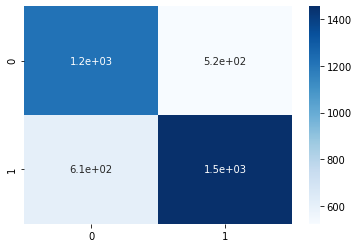

In [31]:
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50,return_sequences=True,input_shape=(11,1)))
  model.add(Dropout(0.1))
  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)

  # Predictions on test data
  preds = model.predict(x_test)
  preds = np.array([1 if y >= 0.5 else 0 for y in preds])
  lstm_results_beta = scores(preds, y_test)

In [32]:
lstm_results_beta

[0.7027880063124671,
 0.7357251136937848,
 0.7057682985942801,
 0.7204354280059376]

Epoch 1/20
48/48 - 2s - loss: 0.6055 - accuracy: 0.6563 - val_loss: 0.6470 - val_accuracy: 0.5992
Epoch 2/20
48/48 - 0s - loss: 0.5452 - accuracy: 0.7283 - val_loss: 0.5238 - val_accuracy: 0.7354
Epoch 3/20
48/48 - 0s - loss: 0.4857 - accuracy: 0.7672 - val_loss: 0.5697 - val_accuracy: 0.7038
Epoch 4/20
48/48 - 0s - loss: 0.4876 - accuracy: 0.7659 - val_loss: 0.5362 - val_accuracy: 0.7344
Epoch 5/20
48/48 - 0s - loss: 0.4629 - accuracy: 0.7868 - val_loss: 0.5729 - val_accuracy: 0.7088
Epoch 6/20
48/48 - 0s - loss: 0.4555 - accuracy: 0.7884 - val_loss: 0.5733 - val_accuracy: 0.6965
Epoch 7/20
48/48 - 0s - loss: 0.4649 - accuracy: 0.7781 - val_loss: 0.5788 - val_accuracy: 0.6931
Epoch 8/20
48/48 - 0s - loss: 0.4358 - accuracy: 0.7974 - val_loss: 0.5822 - val_accuracy: 0.7096
Epoch 9/20
48/48 - 0s - loss: 0.4644 - accuracy: 0.7825 - val_loss: 0.5482 - val_accuracy: 0.7317
Epoch 10/20
48/48 - 0s - loss: 0.4513 - accuracy: 0.7884 - val_loss: 0.5770 - val_accuracy: 0.7170
Epoch 11/20
48/48 -

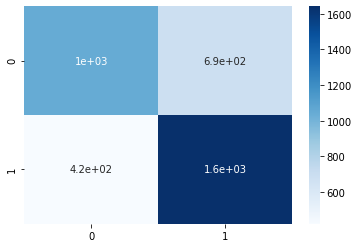

In [29]:
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50,return_sequences=True,input_shape=(11,1)))
  model.add(Dropout(0.1))
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)

  # Predictions on test data
  preds = model.predict(x_test)
  preds = np.array([1 if y >= 0.5 else 0 for y in preds])
  gru_results_beta = scores(preds, y_test)

In [30]:
gru_results_beta

[0.7077853761178328,
 0.7041166380789022,
 0.7959282598158022,
 0.7472127417519909]

XGBoost on new approach

[0]	validation_0-auc:0.784383
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.78591
[2]	validation_0-auc:0.794936
[3]	validation_0-auc:0.798763
[4]	validation_0-auc:0.800806
[5]	validation_0-auc:0.801058
[6]	validation_0-auc:0.801886
[7]	validation_0-auc:0.801478
[8]	validation_0-auc:0.80242
[9]	validation_0-auc:0.804822
[10]	validation_0-auc:0.804515
[11]	validation_0-auc:0.803101
[12]	validation_0-auc:0.803229
[13]	validation_0-auc:0.801766
[14]	validation_0-auc:0.802255
[15]	validation_0-auc:0.802485
[16]	validation_0-auc:0.803993
[17]	validation_0-auc:0.804558
[18]	validation_0-auc:0.804713
[19]	validation_0-auc:0.804486
[20]	validation_0-auc:0.805602
[21]	validation_0-auc:0.804159
[22]	validation_0-auc:0.804091
[23]	validation_0-auc:0.806169
[24]	validation_0-auc:0.806494
[25]	validation_0-auc:0.80419
[26]	validation_0-auc:0.804639
[27]	validation_0-auc:0.805265
[28]	validation_0-auc:0.804684
[29]	validation_0-auc:0.804643
[30]	validation_0-a

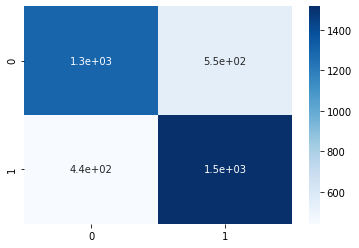

In [33]:
import xgboost as xgb
import numpy as np

X_train = x_train.reshape(x_train.shape[0],x_train.shape[1])
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1])

# XGBoost classifier with Early-stopping
clf = xgb.XGBClassifier(n_jobs=1)
clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="auc",
        eval_set=[(X_test, y_test)])

preds = clf.predict(X_test)
xgboost_results_beta = scores(y_test, preds)

In [34]:
xgboost_results_beta

[0.7396107311941084, 0.7343674260785265, 0.774144098109351, 0.7537313432835822]

### Visualization

In [43]:
from prettytable import PrettyTable
x = PrettyTable()

In [44]:
x.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1 score"]
lstm_results.insert(0,"LSTM")
gru_results.insert(0,"GRU")
xgboost_results.insert(0,"XGBoost")
lstm_results_beta.insert(0,"LSTM with 44 previous data")
gru_results_beta.insert(0,"GRU with 44 previous data")
xgboost_results_beta.insert(0,"XGBoost with 44 previous data")
x.add_row(lstm_results)
x.add_row(gru_results)
x.add_row(xgboost_results)
x.add_row(lstm_results_beta)
x.add_row(gru_results_beta)
x.add_row(xgboost_results_beta)

In [45]:
print(x)

+-------------------------------+--------------------+--------------------+--------------------+--------------------+
|             Model             |      Accuracy      |     Precision      |       Recall       |      F1 score      |
+-------------------------------+--------------------+--------------------+--------------------+--------------------+
|              LSTM             | 0.6925684485006519 | 0.6867219917012448 | 0.796055796055796  | 0.7373579861884607 |
|              GRU              | 0.6933507170795307 | 0.7036535859269283 | 0.7503607503607503 | 0.7262569832402236 |
|            XGBoost            | 0.689960886571056  | 0.7522847522847523 | 0.6988382484361036 | 0.7245772527217975 |
|   LSTM with 44 previous data  | 0.7027880063124671 | 0.7357251136937848 | 0.7057682985942801 | 0.7204354280059376 |
|   GRU with 44 previous data   | 0.7077853761178328 | 0.7041166380789022 | 0.7959282598158022 | 0.7472127417519909 |
| XGBoost with 44 previous data | 0.7396107311941084 | 0